## Introduction

This notebook has the objective of creating a socioeconomic indicator by using exploratory factor analysis.

The ENEM's survey has questions about the student socioeconomic status, such as his parents education, or if his family has durable goods such as cars, washing machine, etc, which is useful in the construction of the indicator.

Because a student socioeconomic status is a good predictor of his college outcomes, its indicator is also usefull for future analysis.

In [62]:
from glob import glob

import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import yaml

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
ses_cols = [
    "educ_pai",
    "educ_mae",
    "renda_fam_pc",
    "tv_cores",
    "dvd",
    "computador",
    "carro",
    "maq_lavar",
    "geladeira",
    "freezer",
    "tel_fixo",
    "celular",
    "internet",
    "tv_assinatura",
    "aspirador_po",
    "empregada",
    "banheiro",
]

In [8]:
sisu_df = pd.read_parquet("../data/interim/sisu/sisu_ufba_enrolled.parquet").drop_duplicates(subset=["ano_enem", "cpf"])

In [9]:
sisu_df.head()

,ano_enem,per_ingr,nome_curso,ds_turno,ds_formacao,cpf,nota_media_enem,tp_sexo,aprovado_primeira_cham,cotista,...,geladeira,freezer,tel_fixo,celular,internet,tv_assinatura,aspirador_po,empregada,banheiro,tipo_escola_ensino_medio
0,2014.0,20151,engenharia de producao,noturno,bacharelado,06201825550,438.56,F,0.0,1,...,1.0,4.0,1.0,1.0,1.0,NaN,NaN,2.0,4.0,publica
2,2014.0,20151,farmacia,integral,bacharelado,06393976543,471.88,F,0.0,1,...,1.0,1.0,1.0,3.0,1.0,1.0,NaN,2.0,1.0,None
3,2014.0,20151,enfermagem,integral,bacharelado,78450748534,481.60,F,0.0,1,...,1.0,4.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0,publica
5,2014.0,20151,historia,noturno,area basica de ingresso (abi),36633089520,485.90,F,0.0,0,...,4.0,4.0,NaN,3.0,1.0,NaN,NaN,2.0,1.0,publica
7,2014.0,20151,odontologia,integral,bacharelado,03124926501,484.56,F,0.0,1,...,1.0,4.0,NaN,2.0,NaN,1.0,NaN,2.0,1.0,publica


In [6]:
sisu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467605 entries, 0 to 72962
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   educ_pai       424276 non-null  float64
 1   educ_mae       443796 non-null  float64
 2   renda_fam_pc   467581 non-null  float64
 3   tv_cores       467578 non-null  float64
 4   dvd            426697 non-null  float64
 5   computador     467578 non-null  float64
 6   carro          467579 non-null  float64
 7   maq_lavar      467578 non-null  float64
 8   geladeira      467579 non-null  float64
 9   freezer        467579 non-null  float64
 10  tel_fixo       399556 non-null  float64
 11  celular        467578 non-null  float64
 12  internet       434199 non-null  float64
 13  tv_assinatura  365553 non-null  float64
 14  aspirador_po   337275 non-null  float64
 15  empregada      467579 non-null  float64
 16  banheiro       467579 non-null  float64
dtypes: float64(17)
memory usage: 6

As we can see, there's a lot of missing values. We are going to use the experimental `IterativeImputer` class from sklearn to perform multivariate missing values imputation.

In [7]:
iter_imp = IterativeImputer(max_iter=50)

In [8]:
sisu_imp = iter_imp.fit_transform(sisu_df)

Let's put it on a DataFrame

In [9]:
sisu_imp = pd.DataFrame(data=np.round(sisu_imp), columns=sisu_df.columns)

In [10]:
sisu_imp.head()

,educ_pai,educ_mae,renda_fam_pc,tv_cores,dvd,computador,carro,maq_lavar,geladeira,freezer,tel_fixo,celular,internet,tv_assinatura,aspirador_po,empregada,banheiro
0,2.0,2.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0
1,2.0,3.0,1.0,2.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0
2,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
3,2.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0
4,2.0,3.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0


Next step: perform a bartlett sphericity test. 

In [11]:
calculate_bartlett_sphericity(sisu_imp)

(3152560.765164489, 0.0)

The test indicate that our data is statistically different from an identity matrix, meaning that there's evidence of intercorrelation in our data. Which is good for performing factor analysis.

In [12]:
_, kmo = calculate_kmo(sisu_imp)
kmo

c:\Users\silasge\Projetos\ufba\ufba-data-analysis\.venv\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.9059721784580378

Our overall kmo score is greater than 0.6, indicating that our dataset is adequate to perform factor analysis.

Let's fit our factor analysis.

In [13]:
fa = FactorAnalyzer(n_factors=1)

In [14]:
fa.fit(sisu_imp)

c:\Users\silasge\Projetos\ufba\ufba-data-analysis\.venv\lib\site-packages\factor_analyzer\factor_analyzer.py:662: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


FactorAnalyzer(n_factors=1, rotation_kwargs={})

In [15]:
pd.DataFrame(data=zip(sisu_imp.columns, fa.loadings_), columns=["cols", "loadings"])

,cols,loadings
0,educ_pai,[0.23332469168458125]
1,educ_mae,[0.2243435111819344]
2,renda_fam_pc,[0.33546804730618107]
3,tv_cores,[0.7302215119412225]
4,dvd,[0.5253088855286853]
5,computador,[0.1662381881408805]
6,carro,[-0.44774575762598545]
7,maq_lavar,[-0.24808888216116287]
8,geladeira,[0.7311222031116601]
9,freezer,[-0.6267966372106248]


In [16]:
sisu_imp["ses"] = fa.transform(sisu_imp)

In [17]:
sisu_imp["ses"] = (sisu_imp["ses"] - sisu_imp["ses"].min()) / (sisu_imp["ses"].max() - sisu_imp["ses"].min())

In [18]:
sisu_imp.head()

,educ_pai,educ_mae,renda_fam_pc,tv_cores,dvd,computador,carro,maq_lavar,geladeira,freezer,tel_fixo,celular,internet,tv_assinatura,aspirador_po,empregada,banheiro,ses
0,2.0,2.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,0.184315
1,2.0,3.0,1.0,2.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,0.180810
2,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.008578
3,2.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,0.293696
4,2.0,3.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.052838


<AxesSubplot: xlabel='ses', ylabel='Count'>

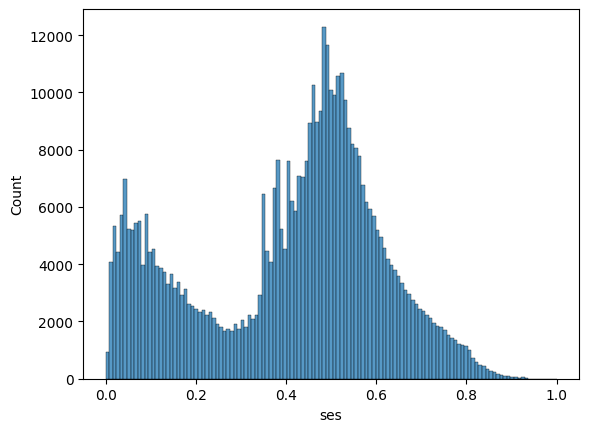

In [19]:
sns.histplot(x="ses", data=sisu_imp)